In [1]:
#@title Install dependencies
from IPython.display import clear_output, display, Image

clear_output()

### Imports

In [2]:
import os
import subprocess
import pandas as pd
import re
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

clear_output()

In [3]:
df = pd.read_csv("YOLO+RAM_merged.csv")
df.drop(df.columns[0], axis=1,inplace=True)

In [4]:
df.head()

,Image,RAM_Tags,YOLO_Tags,location,locationID,videoID,aggID
0,84.jpg,car | city street | crack | crosswalk | curb |...,"1 person, 15 car, 1 traffic light",park,1,1,1100084
1,98.jpg,car | city street | crack | crosswalk | curb |...,14 car,park,1,1,1100098
2,112.jpg,black | car | city street | crack | crosswalk ...,"1 person, 8 car, 1 traffic light",park,1,1,1100112
3,126.jpg,car | city street | crack | crosswalk | curb |...,"1 person, 13 car, 1 traffic light",park,1,1,1100126
4,140.jpg,car | city street | crack | crosswalk | curb |...,"1 person, 9 car, 1 traffic light",park,1,1,1100140


### Co-occurence Matrix

In [5]:
all_tags = set()
for tags in df['RAM_Tags']:
    all_tags.update(tags.split(' | '))
all_tags = sorted(list(all_tags))

# Creating co-occurrence matrices
co_occurrence_overall = pd.DataFrame(index=all_tags, columns=all_tags).fillna(0)

# Function to update co-occurrence matrices
def update_co_occurrence(df, co_occurrence_matrix):
    for _, row in df.iterrows():
        tags = row['RAM_Tags'].split(' | ')
        for i in range(len(tags)):
            for j in range(i+1, len(tags)):
                co_occurrence_matrix.at[tags[i], tags[j]] += 1
                co_occurrence_matrix.at[tags[j], tags[i]] += 1


co_occurrence_overall_total = []

# Updating co-occurrence matrices and normalizing by location
for location, df_location in df.groupby('location'):
    co_occurrence_grouped = co_occurrence_overall.copy()
    update_co_occurrence(df_location, co_occurrence_grouped) # count occurrences
    co_occurrence_grouped /= df_location.shape[0] # normalize the counts for each loc
    co_occurrence_overall_total.append((location,co_occurrence_grouped))

# Average the matrices
co_occurrence_overall = sum(comat_loc[1] for comat_loc in co_occurrence_overall_total) / len(co_occurrence_overall_total)

In [6]:
# Top N co-occuring pairs
def top_n_cooccur_pairs(df, location, top_n):
    pairs = df.stack()
    pairs = pairs[pairs.index.get_level_values(0) < pairs.index.get_level_values(1)]
    top_pairs = pairs.sort_values(ascending=False).head(top_n)
    print(f"Top Co-occurring Pairs in {location.capitalize()}:")
    print(top_pairs)

# Top N tags by overall co-occurrences
def top_n_common_item(df, location, top_n):
    tag_sums = df.sum(axis=1)
    top_n_tags = tag_sums.sort_values(ascending=False).head(top_n)
    print(f"\nTop Tags by Overall Co-occurrences in {location.capitalize()}:")
    print(top_n_tags)

In [7]:
co_occurrence_overall

,advertisement,afro,ambulance,arm,atv,baby,baby carriage,back,backpack,bag,...,wear,wetsuit,wheelchair,wheelie,white,wig,woman,writing,yellow,zebra crossing
advertisement,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000236,0.000000,0.000000,0.0,0.000000,0.000000
afro,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000118,0.0,0.000000,0.000000
ambulance,0.0,0.000000,0.000000,0.000125,0.0,0.000000,0.000059,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.002456,0.000000,0.000294,0.0,0.000059,0.000059
arm,0.0,0.000000,0.000125,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000059,0.000000,0.000000,0.0,0.000000,0.000000
atv,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wig,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000059,0.0,0.000000,0.0,0.000000,0.000000,0.000059,0.0,0.000059,0.000000
woman,0.0,0.000118,0.000294,0.000000,0.0,0.001354,0.004241,0.0,0.000235,0.006544,...,0.001062,0.0,0.000059,0.0,0.009146,0.000059,0.000000,0.0,0.001657,0.039359
writing,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000360,0.000000,0.000000,0.0,0.000000,0.000000
yellow,0.0,0.000000,0.000059,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000353,0.0,0.000000,0.0,0.000177,0.000059,0.001657,0.0,0.000000,0.000118


## Chase

In [8]:
top_n_cooccur_pairs(co_occurrence_overall_total[0][1], co_occurrence_overall_total[0][0], 10) 

Top Co-occurring Pairs in Chase:
city street  road             0.925821
road         street corner    0.915931
city street  street corner    0.879901
crosswalk    road             0.806605
car          road             0.790533
city street  crosswalk        0.790004
pavement     road             0.787178
car          city street      0.771106
cross        road             0.770399
person       road             0.767573
dtype: float64


In [9]:
top_n_common_item(co_occurrence_overall_total[0][1], co_occurrence_overall_total[0][0], 10) 


Top Tags by Overall Co-occurrences in Chase:
road             11.256446
city street      10.754327
street corner    10.655422
crosswalk         9.392264
car               9.256093
pavement          9.132109
person            9.070293
cross             9.066937
intersection      8.658778
walk              8.431473
dtype: float64


## Dumbo

In [95]:
top_n_cooccur_pairs(co_occurrence_overall_total[1][1], co_occurrence_overall_total[1][0], 10) 

Top Co-occurring Pairs in Dumbo:
crosswalk     road            0.992908
intersection  road            0.783688
crosswalk     intersection    0.782270
city street   road            0.732624
              crosswalk       0.726950
              intersection    0.707801
city          road            0.705674
              crosswalk       0.702128
              city street     0.679433
              intersection    0.672340
dtype: float64


In [98]:
top_n_common_item(co_occurrence_overall_total[1][1], co_occurrence_overall_total[1][0], 10) 


Top Tags by Overall Co-occurrences in Dumbo:
road             8.933333
crosswalk        8.866667
intersection     7.141844
city street      6.722695
city             6.456738
car              5.342553
cross            5.060284
street sign      4.941844
person           4.456028
street corner    4.193617
dtype: float64


## Park

In [96]:
top_n_cooccur_pairs(co_occurrence_overall_total[2][1], co_occurrence_overall_total[2][0], 10) 

Top Co-occurring Pairs in Park:
intersection  road             0.837262
drain         road             0.833520
city street   road             0.823045
drain         intersection     0.821549
city street   intersection     0.819678
              drain            0.819304
crack         road             0.817434
road          street corner    0.817434
car           road             0.816685
              intersection     0.813318
dtype: float64


In [99]:
top_n_common_item(co_occurrence_overall_total[2][1], co_occurrence_overall_total[2][0], 10) 


Top Tags by Overall Co-occurrences in Park:
road             9.146652
intersection     8.928545
drain            8.888515
city street      8.783389
crack            8.706697
car              8.695847
street corner    8.684250
curb             8.607183
manhole cover    8.168350
crosswalk        7.940890
dtype: float64


In [35]:
text = ' | '.join(df['RAM_Tags'])
words = text.split('|')
words = [word.strip().lower() for word in words]

# Count the occurrences of each word
word_counts = pd.Series(words).value_counts()

#Make a df for storage
word_counts_df = pd.DataFrame(word_counts)
word_counts_df.reset_index(inplace=True)
word_counts_df.columns = ['Tag','RAM_Count']

In [38]:
word_counts_df

,Tag,RAM_Count
0,road,9186
1,city street,8475
2,street corner,8054
3,crosswalk,7978
4,intersection,7526
...,...,...
300,tennis racket,1
301,school uniform,1
302,paper towel,1
303,cloth,1


In [37]:
word_counts_df_filtered = word_counts_df[~((word_counts_df['RAM_Count']>0.75*len(df)) | (word_counts_df['RAM_Count'] <= 4))]
word_counts_df_filtered

,Tag,RAM_Count
6,cross,5273
7,person,5214
8,walk,4705
9,pavement,4467
10,man,3570
...,...,...
175,jumpsuit,5
176,box,5
177,cardboard box,5
178,package,5


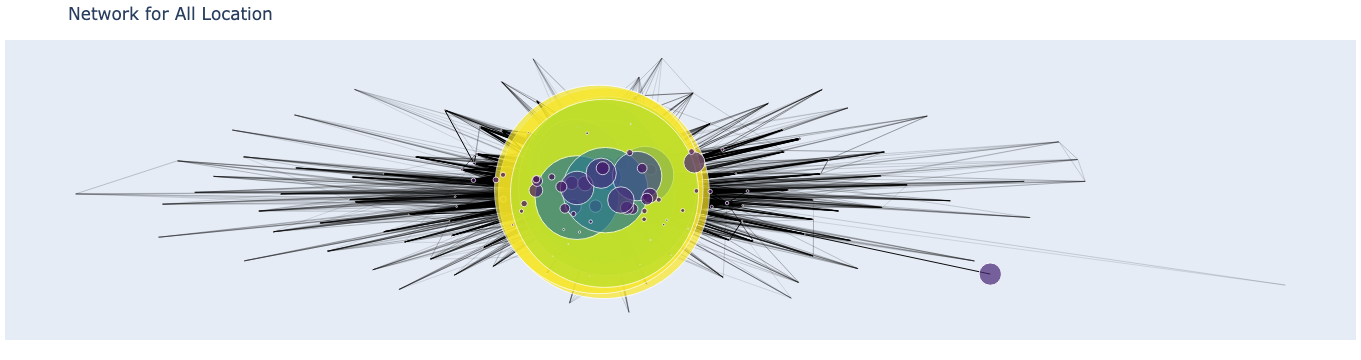

In [40]:
# Function to create a graph from the co-occurrence matrix
def create_graph_from_co_occurrence(co_occurrence_matrix, word_counts_df):
    G = nx.Graph()
    filtered_tags = set(word_counts_df['Tag'])  # Get only the tags present in word_counts_df_filtered
    for i in range(len(co_occurrence_matrix.index)):
        tag1 = co_occurrence_matrix.index[i]
        if tag1 in filtered_tags:
            G.add_node(tag1)
            for j in range(i + 1, len(co_occurrence_matrix.columns)):
                tag2 = co_occurrence_matrix.columns[j]
                if tag2 in filtered_tags:
                   def create_graph_from_co_occurrence(co_occurrence_matrix, word_counts_df):
    G = nx.Graph()
    filtered_tags = set(word_counts_df['Tag'])  # Get only the tags present in word_counts_df_filtered
    for i in range(len(co_occurrence_matrix.index)):
        tag1 = co_occurrence_matrix.index[i]
        if tag1 in filtered_tags:
            G.add_node(tag1)
            for j in range(i + 1, len(co_occurrence_matrix.columns)):
                tag2 = co_occurrence_matrix.columns[j]
                if tag2 in filtered_tags:
                    weight = co_occurrence_matrix.iloc[i, j]
                    if weight >= 3:  # Only add edge if co-occurrence count is 3 or more
                        G.add_edge(tag1, tag2, weight=weight)
    # Assigning node size based on word counts
    for node in G.nodes():
        word_count = word_counts_df[word_counts_df['Tag'] == node]['RAM_Count'].values
        if len(word_count) > 0:
            G.nodes[node]['size'] = word_count[0]  # Taking the word count from word_counts_df
    return G weight = co_occurrence_matrix.iloc[i, j]
                    if weight >= 3:  # Only add edge if co-occurrence count is 3 or more
                        G.add_edge(tag1, tag2, weight=weight)
    # Assigning node size based on word counts
    for node in G.nodes():
        word_count = word_counts_df[word_counts_df['Tag'] == node]['RAM_Count'].values
        if len(word_count) > 0:
            G.nodes[node]['size'] = word_count[0]  # Taking the word count from word_counts_df
    return G

# Creating a Plotly figure
def plot_network(graph, title):
    pos = nx.spring_layout(graph, seed=42)  # Layout for better visualization

    max_weight = max([graph.edges[edge]['weight'] for edge in graph.edges()]) if graph.edges() else 1

    edge_trace = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = graph.edges[edge]['weight']
        edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None], mode='lines', line=dict(width=0.04 * weight, color=f'rgb({int(128 * weight / max_weight)}, {int(128 * weight / max_weight)}, {int(128 * weight / max_weight)})')))  # Adjusting edge width and color

    node_trace = go.Scatter(x=[], y=[], mode='markers', text=[], marker=dict(size=[], color=[], colorscale='Viridis', opacity=0.7))
    for node in graph.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['marker']['size'] += (graph.nodes[node].get('size', 1) * 0.04,)  # Adjusting node size
        connected_nodes = list(graph.neighbors(node))
        top_connected_nodes = sorted(connected_nodes, key=lambda x: graph.edges[(node, x)]['weight'], reverse=True)[:20]  # Get top 20 most connected nodes
        top_connected_nodes_text = "<br>".join(top_connected_nodes) if top_connected_nodes else "None"
        #node_trace['text'] += (node,)
        node_trace['text'] += ([f'Node: {node}<br>Connections: {len(connected_nodes)}<br>Top Connected Nodes: {top_connected_nodes_text}'],)  # Adjusting node text
        node_trace['marker']['color'] += (graph.nodes[node].get('size', 1) * 10,)  # Adjusting node color

    fig = go.Figure(data=[*edge_trace, node_trace],
                    layout=go.Layout(title=title, showlegend=False, hovermode='closest',
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

# Creating graphs from co-occurrence matrices
graph_overall = create_graph_from_co_occurrence(co_occurrence_overall, word_counts_df_filtered)

# Plotting networks
plot_network(graph_overall, "Network for Chase1")

In [41]:
total_nodes = graph_overall.number_of_nodes()
print("Total number of nodes in the graph:", total_nodes)

Total number of nodes in the graph: 174


### Man v/s Woman Distribution

In [42]:
df['man'] = df['RAM_Tags'].str.contains(r'\bman\b|\bboy\b', case=False, regex=True).astype(int)
df['woman'] = df['RAM_Tags'].str.contains(r'\bwoman\b|\bgirl\b', case=False, regex=True).astype(int)